Jon V

In [105]:
from objects import *
import numpy as np
import matplotlib.pyplot as plt
import copy

### Define MD parser. (Code written by Steven T.)

In [2]:
def parse_qe_pwscf_md_output(outfile):
#def parse_qe_pwscf_md_output(path):

    steps={}

    # Get the lines out of the file first
    with open(outfile, 'r') as outf:
        lines = outf.readlines()

    # Because every step is marked by a total energy printing with the !
    # as the first character of the line, partition the file of output
    # into all different chunks of run data

    # Get the indexes to carve up the document later
    split_indexes=[N for N in range(len(lines)) if '!'==lines[N][0]]

    # Cut out the first chunk 
    # TODO: Analyze first chunk
    first_chunk=lines[0:split_indexes[0]]

    step_chunks = []
    # Carve up into chunks
    for n in range(len(split_indexes)):
        step_chunks.append(lines[split_indexes[n]:split_indexes[n+1] if n!=len(split_indexes)-1 else len(lines)]) 



    # Iterate through chunks
    for current_chunk in step_chunks:


        # Iterate through to find the bounds of regions of interest

        # Forces
        force_start_line = [line for line in current_chunk if 'Forces acting on atoms' in line][0]
        force_end_line   = [line for line in current_chunk if 'Total force' in line][0]
        force_start_index = current_chunk.index(force_start_line)+2
        force_end_index = current_chunk.index(force_end_line)-2

        # Positions
        atoms_start_line = [line for line in current_chunk if 'ATOMIC_POSITIONS' in line][0]
        atoms_end_line   = [line for line in current_chunk if 'kinetic energy' in line][0]
        atoms_start_index = current_chunk.index(atoms_start_line)+1
        atoms_end_index = current_chunk.index(atoms_end_line)-3

        # Misc Facts
        temperature_line = [ line for line in current_chunk if 'temperature' in line][0]
        dyn_line = [line for line in current_chunk if 'Entering Dynamics' in line][0]
        dyn_index = current_chunk.index(dyn_line)
        time_index = dyn_index+1

        # Parse through said regions of interest to get the information out

        forces = []
        for line in current_chunk[force_start_index:force_end_index+1]:
            forceline= line.split('=')[-1].split()
            forces.append([float(forceline[0]),float(forceline[1]),float(forceline[2])])
        total_force = float(force_end_line.split('=')[1].strip().split()[0])
        SCF_corr    = float(force_end_line.split('=')[2].strip()[0])


        positions =[]
        elements=[]
        for line in current_chunk[atoms_start_index:atoms_end_index+1]:
            atomline = line.split()
            elements.append(atomline[0])
            positions.append([float(atomline[1]),float(atomline[2]),float(atomline[3])])

        # Get Misc info 
        toten = float(current_chunk[0].split('=')[-1].strip().split()[0])
        temperature_line = temperature_line.split('=')[-1]
        temperature = float(temperature_line.split()[0])
        iteration = int(dyn_line.split('=')[-1])
        timeline = current_chunk[time_index].split('=')[-1].strip().split()[0]
        time = float( timeline)
        Ekin = float(atoms_end_line.split('=')[1].strip().split()[0])


        # Record the data associated with this step
        steps[iteration]={'iteration':iteration,
                           'forces':forces, 
                           'positions':positions,
                           'elements':elements,
                           'temperature':temperature,
                           'time':time,
                           'energy':toten,
                           'ekin':Ekin,
                           'kinetic energy':Ekin,
                           'total energy':toten,
                           'total force':total_force,
                           'SCF correction':SCF_corr}

    return(steps)

### Parse Si MD file.

In [3]:
outfile ='/Users/jonpvandermause/Research/GP/ML-electron-density/Si_Supercell_MD/si.md.out'
Si_MD_Parsed = parse_qe_pwscf_md_output(outfile)

### Calculate distances efficiently.

In [4]:
# get bravais matrix inverse
alat = 5.431
brav_mat = np.array([[0.0, alat/2, alat/2], [alat/2, 0.0, alat/2], [alat/2, alat/2, 0.0]])*3
brav_inv = np.linalg.inv(brav_mat)

# get bravais vectors
vec1 = brav_mat[:,0]
vec2 = brav_mat[:,1]
vec3 = brav_mat[:,2]

In [5]:
def get_cutoff_vecs(vec, brav_mat, brav_inv, vec1, vec2, vec3, cutoff):
    # get bravais coefficients
    coeff = np.matmul(brav_inv, vec)
    
    # get bravais coefficients for atoms within one super-super-cell
    coeffs = [[],[],[]]
    for n in range(3):
        coeffs[n].append(coeff[n])

        if coeff[n] > 0:
            coeffs[n].append(coeff[n]-1)

        elif coeff[n] < 0:
            coeffs[n].append(coeff[n]+1)

    # get vectors within cutoff
    vecs = []
    dists = []
    for m in range(len(coeffs[0])):
        for n in range(len(coeffs[1])):
            for p in range(len(coeffs[2])):
                vec_curr = coeffs[0][m]*vec1 + coeffs[1][n]*vec2 + coeffs[2][p]*vec3
                
                dist = np.linalg.norm(vec_curr)

                if dist < cutoff:
                    vecs.append(vec_curr)
                    dists.append(dist)
                    
    return vecs, dists

### Create force representation from Botu (2015).

In [141]:
# given a supercell and an atom number, return symmetry vectors
def symmetrize_forces(pos, atom, cutoff=8, eta_lower=-1, eta_upper=2, eta_length=8):

    # set atom position
    pos_atom = np.array(pos[atom])
    etas = np.logspace(eta_lower, eta_upper, eta_length)

    # initialize symmetry vectors
    symm_x = np.zeros([len(etas)])
    symm_y = np.zeros([len(etas)])
    symm_z = np.zeros([len(etas)])

    # loop through positions
    atom_count = 0
    for n in range(len(pos)):
        if n != atom:
            # position relative to reference atom
            diff_curr = np.array(pos[n]) - pos_atom

            # get images within cutoff
            vecs, dists = get_cutoff_vecs(diff_curr, brav_mat, brav_inv, vec1, vec2, vec3, cutoff)
            
            # count the number of atoms in the environment
            atom_count +=len(vecs)

            # symmetrize according to Botu (2015)
            for vec, dist in zip(vecs, dists):
                cut_val = 0.5 * (np.cos(np.pi * dist / cutoff) + 1)

                # get symmetry vectors
                symm_x += [(vec[0] / dist) * \
                                    np.exp(-(dist / eta)**2) * cut_val for eta in etas]

                symm_y += [(vec[1] / dist) * \
                        np.exp(-(dist / eta)**2) * cut_val for eta in etas]

                symm_z += [(vec[2] / dist) * \
                    np.exp(-(dist / eta)**2) * cut_val for eta in etas]
                
    return symm_x, symm_y, symm_z

In [142]:
# for a given supercell, calculate symmetry vectors for each atom
def get_symmetry_dictionary(pos, forces, training_dictionary, cutoff=8, eta_lower=-0.9, eta_upper=2, eta_length=8):
    for n in range(len(pos)):
        # get symmetry vectors
        symm_x, symm_y, symm_z = symmetrize_forces(pos, n, cutoff, eta_lower, eta_upper, eta_length)
        
        # append symmetry vectors
        training_dictionary['symms'].append(symm_x)
        training_dictionary['symms'].append(symm_y)
        training_dictionary['symms'].append(symm_z)
        
        # append force components
        training_dictionary['forces'].append(forces[n][0])
        training_dictionary['forces'].append(forces[n][1])
        training_dictionary['forces'].append(forces[n][2])

In [143]:
# normalize the symmetry vectors and forces
def normalize_symm(td):
    symm_len = len(td['symms'][0])
    td_size = len(td['symms'])

    # initialize normalized symmetry vector
    td['symm_norm'] = copy.deepcopy(td['symms'])

    for m in range(symm_len):  
        # calculate standard deviation of current symmetry element
        vec = np.array([td['symms'][n][m] for n in range(td_size)])
        vec_std = np.std(vec)

        # normalize the current element
        for n in range(td_size):
            td['symm_norm'][n][m] = td['symm_norm'][n][m] / vec_std

### Create force model from ab initio Si run.

In [144]:
# get training indices
db_size = 1000
train_pts = round(db_size / 10) # ten percent
train_indices = [int(round(n)) for n in np.linspace(1,db_size,train_pts)]

In [145]:
# initialize training dictionary, where positions, symmetry vectors, and forces are stored
td = {'symms':[], 'forces':[]}

# loop through training points (this takes awhile)
for n in range(train_pts):
    # get current positions and forces
    pos = Si_MD_Parsed[train_indices[n]]['positions']
    forces = Si_MD_Parsed[train_indices[n]]['forces']
    
    # symmetrize and update the training set
    get_symmetry_dictionary(pos, forces, td)

In [146]:
# normalize the symmetry vectors
normalize_symm(td)

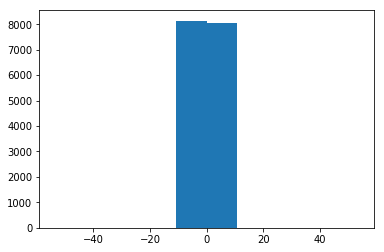

In [148]:
# plot a histogram of the normalized components
m = 0
vec = np.array([td['symm_norm'][n][m] for n in range(td_size)])

plt.hist(vec)
plt.show()

### Plot symmetry vectors.

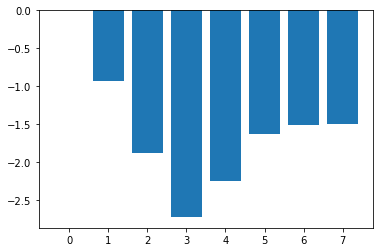

the normalized symmetry vector is [-3.68667163e-08 -9.27912160e-01 -1.87145632e+00 -2.72385265e+00
 -2.24891381e+00 -1.62688706e+00 -1.51188856e+00 -1.49443339e+00]
the force component is 0.02473962


In [182]:
# define eta grid
eta_lower = -1
eta_upper = 2
eta_length = 8
etas = np.logspace(eta_lower, eta_upper, eta_length)

# choose training point to examine
pt = 700

# set symmetry vector
symm = td['symm_norm'][pt]
xs = np.arange(0,len(etas),1)
plt.bar(xs,symm)
plt.show()

# print the force component corresponding to this symmetry vector
print('the normalized symmetry vector is '+str(td['symm_norm'][pt]))
print('the force component is '+str(td['forces'][pt]))